# Data Preprocessing Notebook

### Imports and helper functions

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import os

def load_ephys(ephys_file: str, num_samples: int = -1, start = 0, stop = 0, nchannels: int = 16, dtype = np.uint32, order = 'F') -> np.array:
    '''
    Load and reshape binary electrophysiology data into a NumPy array.

    This function is designed to read binary files containing electrophysiology 
    (ephys) data. It loads the specified number of samples from the file and 
    reshapes them into a 2D NumPy array, where each row represents a channel.

    Parameters:
    ephys_file (str): Path to the binary file containing electrophysiology data.
    num_samples (int): Number of samples to read from the file.
    nchannels (int, optional): Number of channels in the ephys data. Defaults to 16.

    Returns:
    np.array: A 2D NumPy array of the electrophysiology data, reshaped into
              (nchannels, number_of_samples_per_channel).
    '''
  
    # reading in binary data
    num_samples = num_samples * nchannels
    ephys_bin = np.fromfile(ephys_file, dtype=dtype, count = num_samples)
    
    # ensuring equal samples from each channel
    num_complete_sets = len(ephys_bin) // nchannels
    ephys_bin = ephys_bin[:num_complete_sets * nchannels]

    # reshape 1d array into nchannels x num_samples NumPy array
    ephys_data = np.reshape(ephys_bin, (nchannels, -1), order=order)

    # removing start seconds from beggining, and stop from end of signal; default is 0
    start = start * 30000
    stop = stop * 30000

    if stop == 0:
        ephys = ephys_data[:, start:]
    else:
        ephys = ephys_data[:, start: -stop]

    return ephys


### Defining the data directory and parameters

In [14]:
data_dir = r"C:\Users\smearlab\clickbait-ephys"
save_dir = r"C:\Users\smearlab\clickbait-ephys\preprocessed_data"
fig_dir = r"C:\Users\smearlab\clickbait-ephys\figures"
mice = ['6000', '6001', '6002', '6003']
session_offset = 3

os.makedirs(save_dir, exist_ok=True)
open_ephys_dir = os.path.join(data_dir, "open-ephys")

### 📊 Extracting OpenEphys Data (Sniff, Ephys, TTLs) and Restructuring the Data

The script processes raw OpenEphys data, extracting relevant signals (LFP, MUA, sniff, TTLs) and saving them in a structured format. The preprocessed data will be stored in the `preprocessed_data` directory with the following structure:


```
preprocessed_data
├── <animal_id>
│   ├── <session_id>
│   │   ├── lfp.npy
│   │   ├── mua.npy
│   │   ├── sniff.npy
│   │   └── ttls.npy
```



#### 🗂️ **Data Descriptions:**

- **`lfp.npy`** *(Local Field Potential)*  
  - **Description:** Represents the slow oscillatory activity of the brain.  
  - **Processing:** Low-pass filtered at **300 Hz** to capture relevant neural dynamics.

- **`mua.npy`** *(Multi-Unit Activity)*  
  - **Description:** Captures high-frequency spiking activity from multiple neurons.  
  - **Processing:** Band-pass filtered between **300 Hz and 6 kHz** and **median common average referenced** within regions to reduce noise.

- **`sniff.npy`** *(Sniff Data)*  
  - **Description:** Raw sniffing signal representing respiratory behavior.  
  - **Processing:** Extracted directly from the raw data without additional filtering.

- **`ttls.npy`** *(TTL Pulses)*  
  - **Description:** Raw TTL (Transistor-Transistor Logic) pulses used as event markers.  
  - **Processing:** Saved in raw format to preserve precise event timing.

---





In [7]:
# List all files in the open-ephys directory
all_files = os.listdir(open_ephys_dir)

# Loop through each mouse
for mouse in mice:
    # Filter files related to the current mouse
    mouse_sessions = [f.strip() for f in all_files if mouse in f]

    # Process each session for the current mouse
    for session in mouse_sessions:
        print(f"Processing session: {session}")

        # Extract date and session number
        date = session[:10]
        try:
            session_num = int(date[-2:]) - session_offset
        except ValueError:
            print(f"Invalid date format in session: {session}")
            continue

        # Build the path to the data directory
        session_path = os.path.join(open_ephys_dir, session)

        # Check if the session directory exists
        if not os.path.isdir(session_path):
            print(f"Session directory not found: {session_path}")
            continue

        # Get the first subdirectory (assumed to be the "Record Node" folder)
        try:
            record_node = os.listdir(session_path)[0]
        except IndexError:
            print(f"No files found in session: {session_path}")
            continue

        # Build the path to the continuous data directory
        continuous_dir = os.path.join(session_path, record_node, 'experiment1', 'recording1', 'continuous')

        # Check if the continuous directory exists
        if not os.path.isdir(continuous_dir):
            print(f"Continuous directory not found: {continuous_dir}")
            continue

        # Get the acquisition board folder
        try:
            acquisition_board = os.listdir(continuous_dir)[0]
        except IndexError:
            print(f"No acquisition board folder found in: {continuous_dir}")
            continue

        # Final path to the continuous.dat file
        data_path = os.path.join(continuous_dir, acquisition_board, 'continuous.dat')
        print(f"Data path: {data_path}")

        # Load the electrophysiological data
        if os.path.exists(data_path):
            try:

                # Loading the data
                data = load_ephys(data_path, nchannels=40, dtype=np.int16, order='F')

                # Making the data directory
                data_dir = os.path.join(save_dir, mouse, str(session_num))
                os.makedirs(data_dir, exist_ok=True)

                # Extracting the ephys, sniff, and ttl timeseries
                ephys = data[:32, :]
                sniff = data[-1, :]
                ttls = data[-2, :]

                # lowpass filtering the ephys data to get the LFP
                sos = signal.butter(4, 300, 'lowpass', fs=30000, output='sos')
                lfps = signal.sosfiltfilt(sos, ephys)

                # bandpass filtering the ephys data to get the MUA
                sos = signal.butter(4, [300, 6000], 'bandpass', fs=30000, output='sos')
                mua = signal.sosfiltfilt(sos, ephys)

                # median common average referencing the multiunit activity
                mua[:16, :] -= np.median(mua[:16, :], axis=0)
                mua[16:, :] -= np.median(mua[16:, :], axis=0)

                # converting back to int16
                lfps = lfps.astype(np.int16)
                mua = mua.astype(np.int16)
                sniff = sniff.astype(np.int16)
                ttls = ttls.astype(np.int16)

                # Ensuring files do not already exist
                if os.path.exists(os.path.join(data_dir, 'lfp.npy')) or \
                   os.path.exists(os.path.join(data_dir, 'mua.npy')) or \
                   os.path.exists(os.path.join(data_dir, 'sniff.npy')) or \
                   os.path.exists(os.path.join(data_dir, 'ttls.npy')):
                    print(f"Files already exist for {session}, skipping...")
                    continue

                # Saving the data as binary files
                np.save(os.path.join(data_dir, 'lfp.npy'), lfps)
                np.save(os.path.join(data_dir, 'mua.npy'), mua)
                np.save(os.path.join(data_dir, 'sniff.npy'), sniff)
                np.save(os.path.join(data_dir, 'ttls.npy'), ttls)

                print(f"Loaded data successfully for {session}\n")
            except Exception as e:
                print(f"Error loading data from {data_path}: {e}")
        else:
            print(f"Data path not found: {data_path}")

Processing session: 2025-02-03_14-25-38_6000
Data path: C:\Users\smearlab\clickbait-ephys\open-ephys\2025-02-03_14-25-38_6000\Record Node 104\experiment1\recording1\continuous\Acquisition_Board-102.Rhythm Data\continuous.dat
Loaded data successfully for 2025-02-03_14-25-38_6000

Processing session: 2025-02-04_14-04-31_6000
Data path: C:\Users\smearlab\clickbait-ephys\open-ephys\2025-02-04_14-04-31_6000\Record Node 110\experiment1\recording1\continuous\Acquisition_Board-108.Rhythm Data\continuous.dat
Loaded data successfully for 2025-02-04_14-04-31_6000

Processing session: 2025-02-05_14-03-34_6000
Data path: C:\Users\smearlab\clickbait-ephys\open-ephys\2025-02-05_14-03-34_6000\Record Node 110\experiment1\recording1\continuous\Acquisition_Board-108.Rhythm Data\continuous.dat
Loaded data successfully for 2025-02-05_14-03-34_6000

Processing session: 2025-02-06_16-02-02_6000
Data path: C:\Users\smearlab\clickbait-ephys\open-ephys\2025-02-06_16-02-02_6000\Record Node 110\experiment1\record

### 📈 Visualizing LFP, MUA, Sniff, and TTL Signals

This script generates time-series plots for electrophysiological recordings, including **Local Field Potentials (LFPs)**, **Multi-Unit Activity (MUA)**, **Sniff Signals**, and **TTL Pulses**. The plots help visualize neural dynamics, respiratory behavior, and event markers across different mice, sessions, and channels.

#### 🗂️ **Data Source:**
The data is loaded from preprocessed `.npy` files:
- **`lfp.npy`**: Local Field Potentials (LFP)
- **`mua.npy`**: Multi-Unit Activity (MUA)
- **`sniff.npy`**: Sniff data (raw)
- **`ttls.npy`**: TTL event markers (raw)

#### 🔍 **Plotting Details:**
- **Number of Segments:** The data is divided into `n_segments` for visualization.  
- **Segment Length:** Each segment is **10 seconds** long.  
- **Sampling Rate:** Signals are sampled at **30 kHz**.  
- **Channels:** LFP and MUA are plotted for each recording channel.

#### 🎨 **Plot Aesthetics:**
- **Consistent Color Palette:**  
  - LFP → Blue (#1f77b4)  
  - MUA → Orange (#ff7f0e)  
  - Sniff → Green (#2ca02c)  
  - TTL → Red (#d62728)  
- **Gridlines:** Added for improved readability.  
- **Shared X-Axis:** All signals are aligned on the time axis (in seconds).  
- **Clean Layout:** Titles, labels, and spacing are optimized for clarity.

#### 💾 **Output Structure:**
The figures are saved in the following format:

```
<fig_dir>
├── <mouse_id>
| ├── <session_id>
| | ├── channel_<channel_num>segment<segment_num>.png
```

Each plot displays:
- **Mouse ID**
- **Session ID**
- **Channel Number**
- **Segment Start Time (in seconds)**

---

This visualization workflow facilitates quick inspection of neural recordings, allowing researchers to identify patterns, artifacts, and key features in the data across multiple sessions and subjects.








KeyboardInterrupt: 

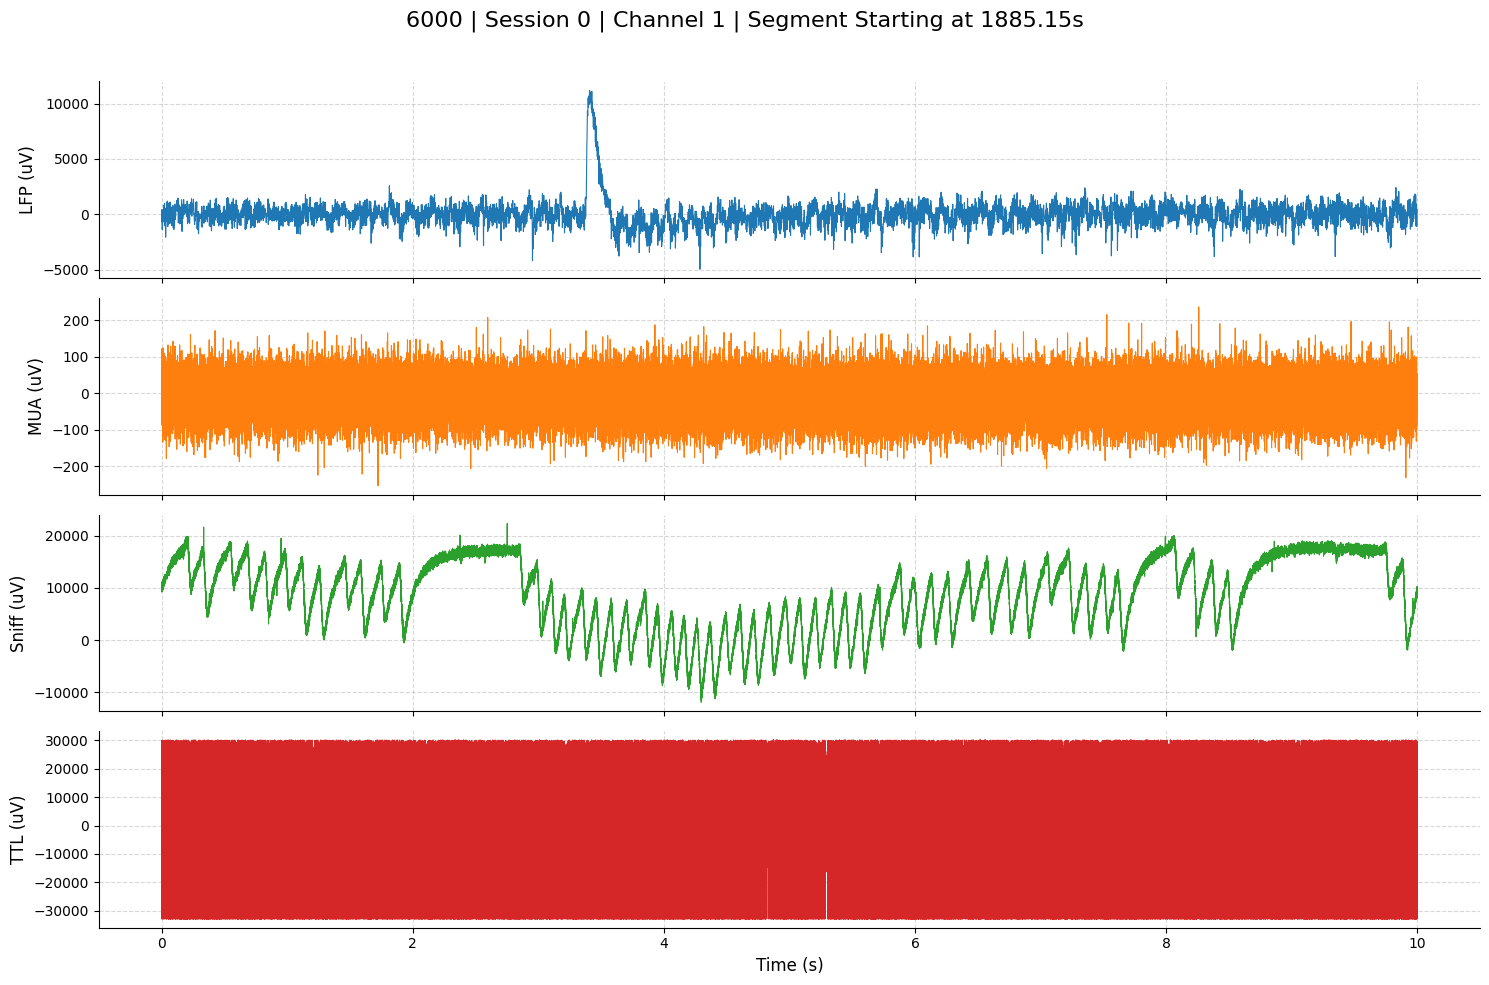

In [15]:
os.makedirs(fig_dir, exist_ok=True)

# Constants
n_segments = 5        # Number of segments to plot
length = 10           # Length of each segment (in seconds)
fs = 30000            # Sampling frequency (Hz)
time_axis = np.arange(0, length, 1/fs)  # Time vector for plotting (in seconds)

# Custom color palette
colors = {
    'LFP': '#1f77b4',
    'MUA': '#ff7f0e',
    'Sniff': '#2ca02c',
    'TTL': '#d62728'
}

# Helper function to plot signals
def plot_signals(lfp, mua, sniff, ttls, channel, seg, mouse, session, save_path):
    fig, ax = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
    fig.suptitle(f"{mouse} | Session {session} | Channel {channel} | Segment Starting at {seg/fs:.2f}s", fontsize=16)

    # Plotting signals
    signals = {'LFP': lfp, 'MUA': mua, 'Sniff': sniff, 'TTL': ttls}
    for i, (label, data) in enumerate(signals.items()):
        if label in ['LFP', 'MUA']:
            ax[i].plot(time_axis, data[channel, seg:seg + length * fs], color=colors[label], linewidth=0.8)
        else:
            ax[i].plot(time_axis, data[seg:seg + length * fs], color=colors[label], linewidth=0.8)

        ax[i].set_ylabel(f'{label} (uV)', fontsize=12)
        ax[i].grid(True, linestyle='--', alpha=0.5)

    ax[-1].set_xlabel('Time (s)', fontsize=12)
    sns.despine()

    # Save figure
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.savefig(save_path, dpi=300)
    plt.close()


# Looping through mice and sessions
for mouse in mice:
    mouse_sessions = os.listdir(os.path.join(save_dir, mouse))
    for session in mouse_sessions:
        # Loading data
        session_path = os.path.join(save_dir, mouse, session)
        lfp = np.load(os.path.join(session_path, 'lfp.npy'))
        mua = np.load(os.path.join(session_path, 'mua.npy'))
        sniff = np.load(os.path.join(session_path, 'sniff.npy'))
        ttls = np.load(os.path.join(session_path, 'ttls.npy'))

        nchannels, num_samples = lfp.shape

        # Create figure directory
        current_fig_dir = os.path.join(fig_dir, mouse, session)
        os.makedirs(current_fig_dir, exist_ok=True)

        # Get equally spaced segment start times
        start_times = np.linspace(0, num_samples - length * fs, n_segments).astype(int)

        # Plotting signals for each channel and segment
        for channel in range(nchannels):
            for seg in start_times:
                save_path = os.path.join(current_fig_dir, f"channel_{channel}_segment_{seg}.png")
                plot_signals(lfp, mua, sniff, ttls, channel, seg, mouse, session, save_path)